# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Feature engineering
4. Modelling

---

## 1. Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [9]:
df = pd.read_csv('client_data-Copy1.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [10]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with predictive power.

In [13]:
price_df = pd.read_csv('price_data-Copy1.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [14]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [15]:
df = pd.merge(df, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,-0.006192,0.162916


---

## Average price changes across periods

We can now enhance the feature that our colleague made by calculating the average price changes across individual periods, instead of the entire year.

In [16]:
# Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [17]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [18]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,43.648,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,13.800,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,13.856,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,13.200,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,19.800,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


This feature may be useful because it adds more granularity to the existing feature that my colleague found to be useful. Instead of looking at differences across an entire year, we have now created features that look at mean average price differences across different time periods (`off_peak`, `peak`, `mid_peak`). The dec-jan feature may reveal macro patterns that occur over an entire year, whereas inter-time-period features may reveal patterns on a micro scale between months.

---

## Max price changes across periods and months

Another way we can enhance the feature from our colleague is to look at the maximum change in prices across periods and months.

In [19]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [20]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [21]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [22]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


I thought that calculating the maximum price change between months and time periods would be a good feature to create because I was trying to think from the perspective of a PowerCo client. As a Utilities customer, there is nothing more annoying than sudden price changes between months, and a large increase in prices within a short time span would be an influencing factor in causing me to look at other utilities providers for a better deal. Since we are trying to predict churn for this use case, I thought this would be an interesting feature to include.

### Transforming dates into months

- months_activ = Number of months active until reference date (Jan 2016)
- months_to_end = Number of months of the contract left until reference date (Jan 2016)
- months_modif_prod = Number of months since last modification until reference date (Jan 2016)
- months_renewal = Number of months since last renewal until reference date (Jan 2016)

In [23]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [24]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [25]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693,30,5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471,76,7,76,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,68,3,68,8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471,69,2,69,9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733,71,2,71,9


### Transforming Boolean data

#### has_gas

We simply want to transform this column from being categorical to being a binary flag

In [26]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.100544
1,0.081856


If a customer also buys gas from PowerCo, it shows that they have multiple products and are a loyal customer to the brand. Hence, it is no surprise that customers who do not buy gas are almost 2% more likely to churn than customers who also buy gas from PowerCo. Hence, this is a useful feature.

### Transforming categorical data



#### channel_sales

In [27]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

We have 8 categories, so we will create 8 dummy variables from this column. However, as you can see the last 3 categories in the output above, show that they only have 11, 3 and 2 occurrences respectively. Considering that our dataset has about 14000 rows, this means that these dummy variables will be almost entirely 0 and so will not add much predictive power to the model at all (since they're almost entirely a constant value and provide very little).

For this reason, we will drop these 3 dummy variables.

In [28]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,44.26693,30,5,2,6,0,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,44.44471,76,7,76,4,1,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,44.44471,68,3,68,8,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,44.44471,69,2,69,9,0,0,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,24.43733,71,2,71,9,1,0,0,0,0


#### origin_up

In [29]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

Similar to `channel_sales` the last 3 categories in the output above show very low frequency, so we will remove these from the features after creating dummy variables.

In [30]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,71,9,1,0,0,0,0,1,0,0


### Transforming numerical data


In [31]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


We can see that the standard deviation for most of these features is quite high.

In [32]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [33]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,4.223939,0.779244,2.264646,2.962177,1.784610,0.966726,1.517203,0.137283,0.050491,43.130056
std,0.884515,1.717071,1.769305,0.683592,1.584986,5.108289,0.571481,0.024623,0.049037,4.485988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.754023,0.000000,0.000000,2.695477,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149727,0.000000,2.899547,3.046836,2.498311,0.000000,1.296555,0.143166,0.084138,44.311378
75%,4.610285,0.000000,3.529430,3.380716,3.242231,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


Now we can see that for the majority of the features, their standard deviation is much lower after transformation. This is a good thing, it shows that these features are more stable and predictable now.

Let's quickly check the distributions of some of these features too.

C:\Users\Vansheta\AppData\Local\Temp\ipykernel_4128\3336105285.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
C:\Users\Vansheta\AppData\Local\Temp\ipykernel_4128\3336105285.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df[df["has_gas"]==1]["cons_

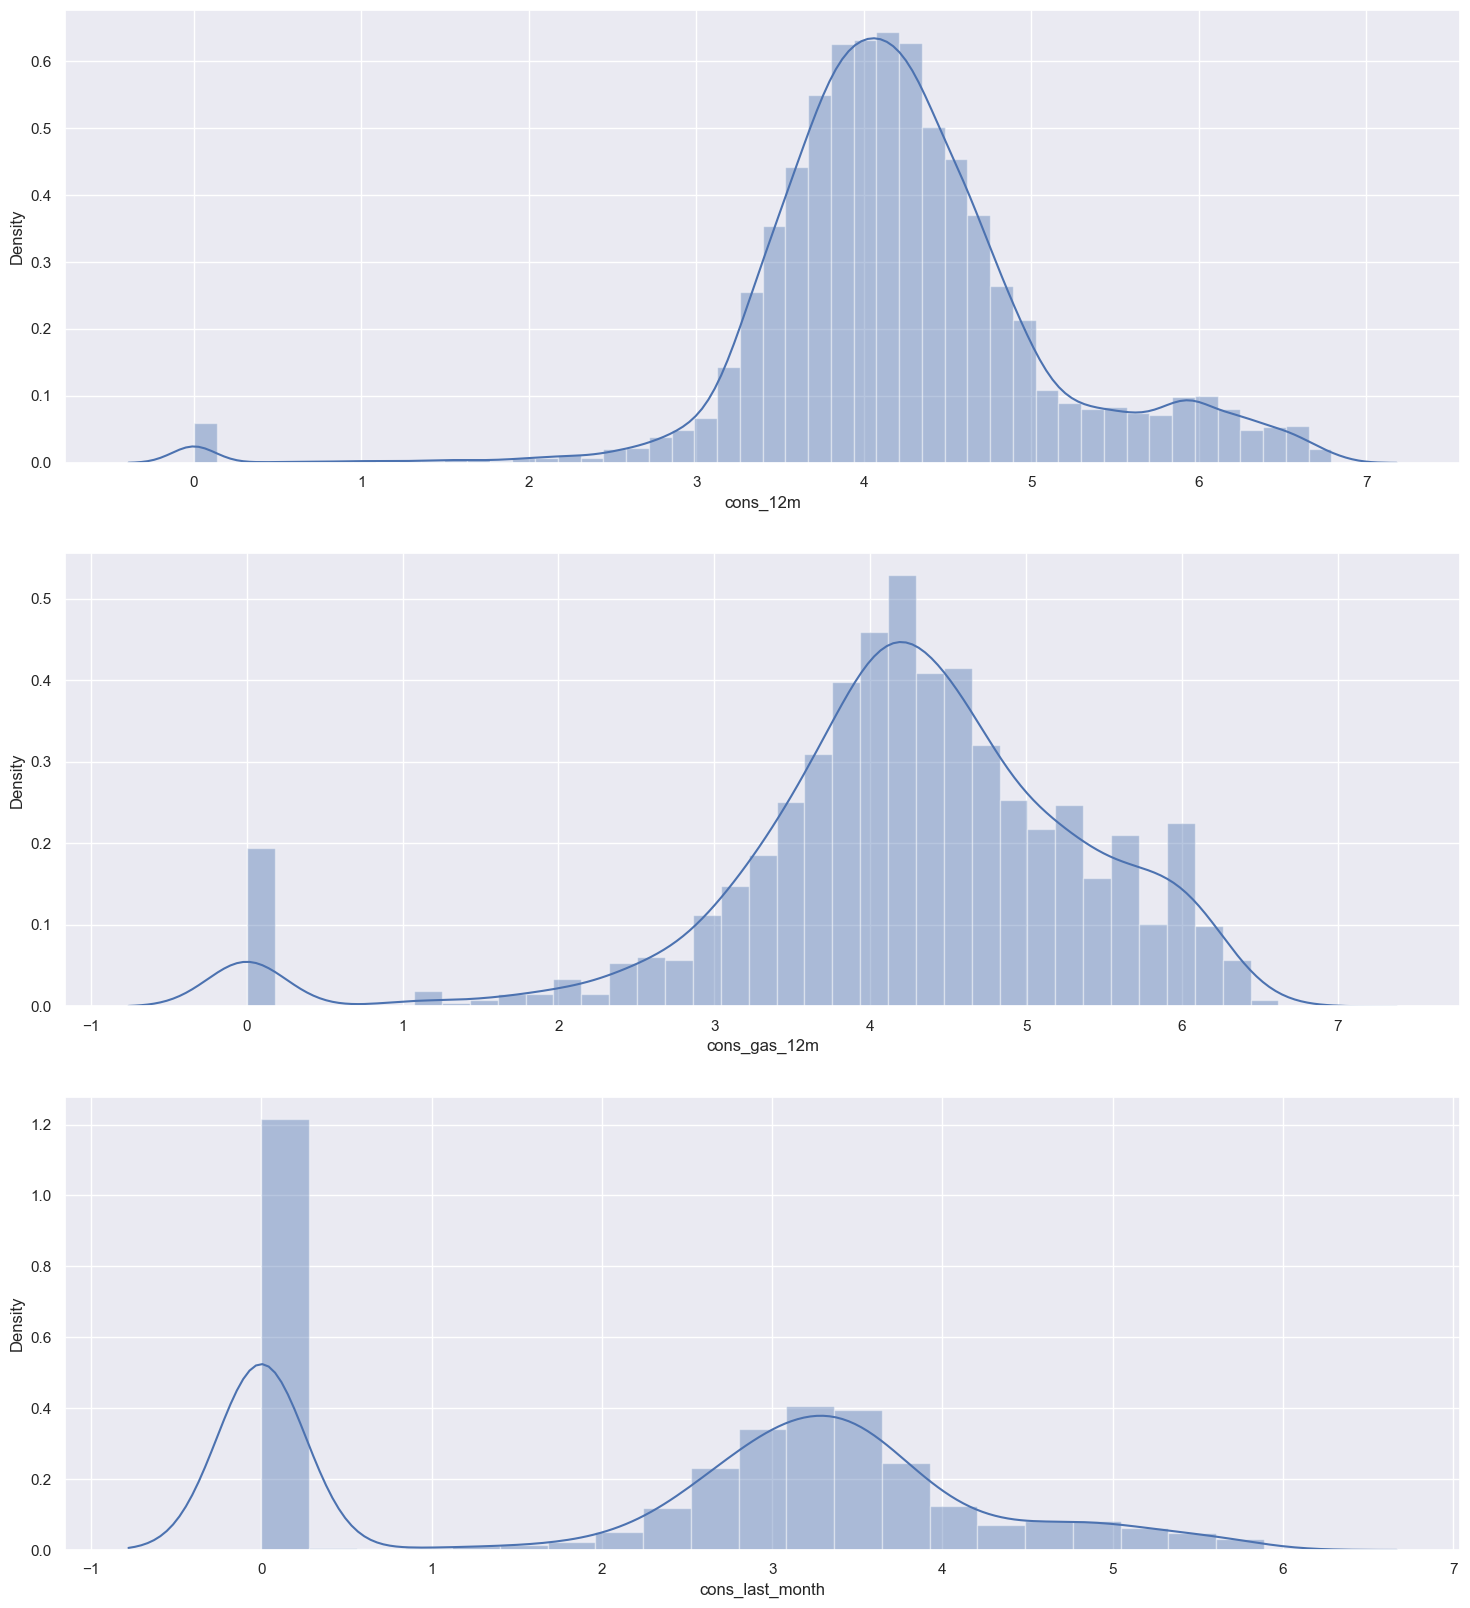

In [34]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

### Correlations



In [35]:
correlation = df.corr()

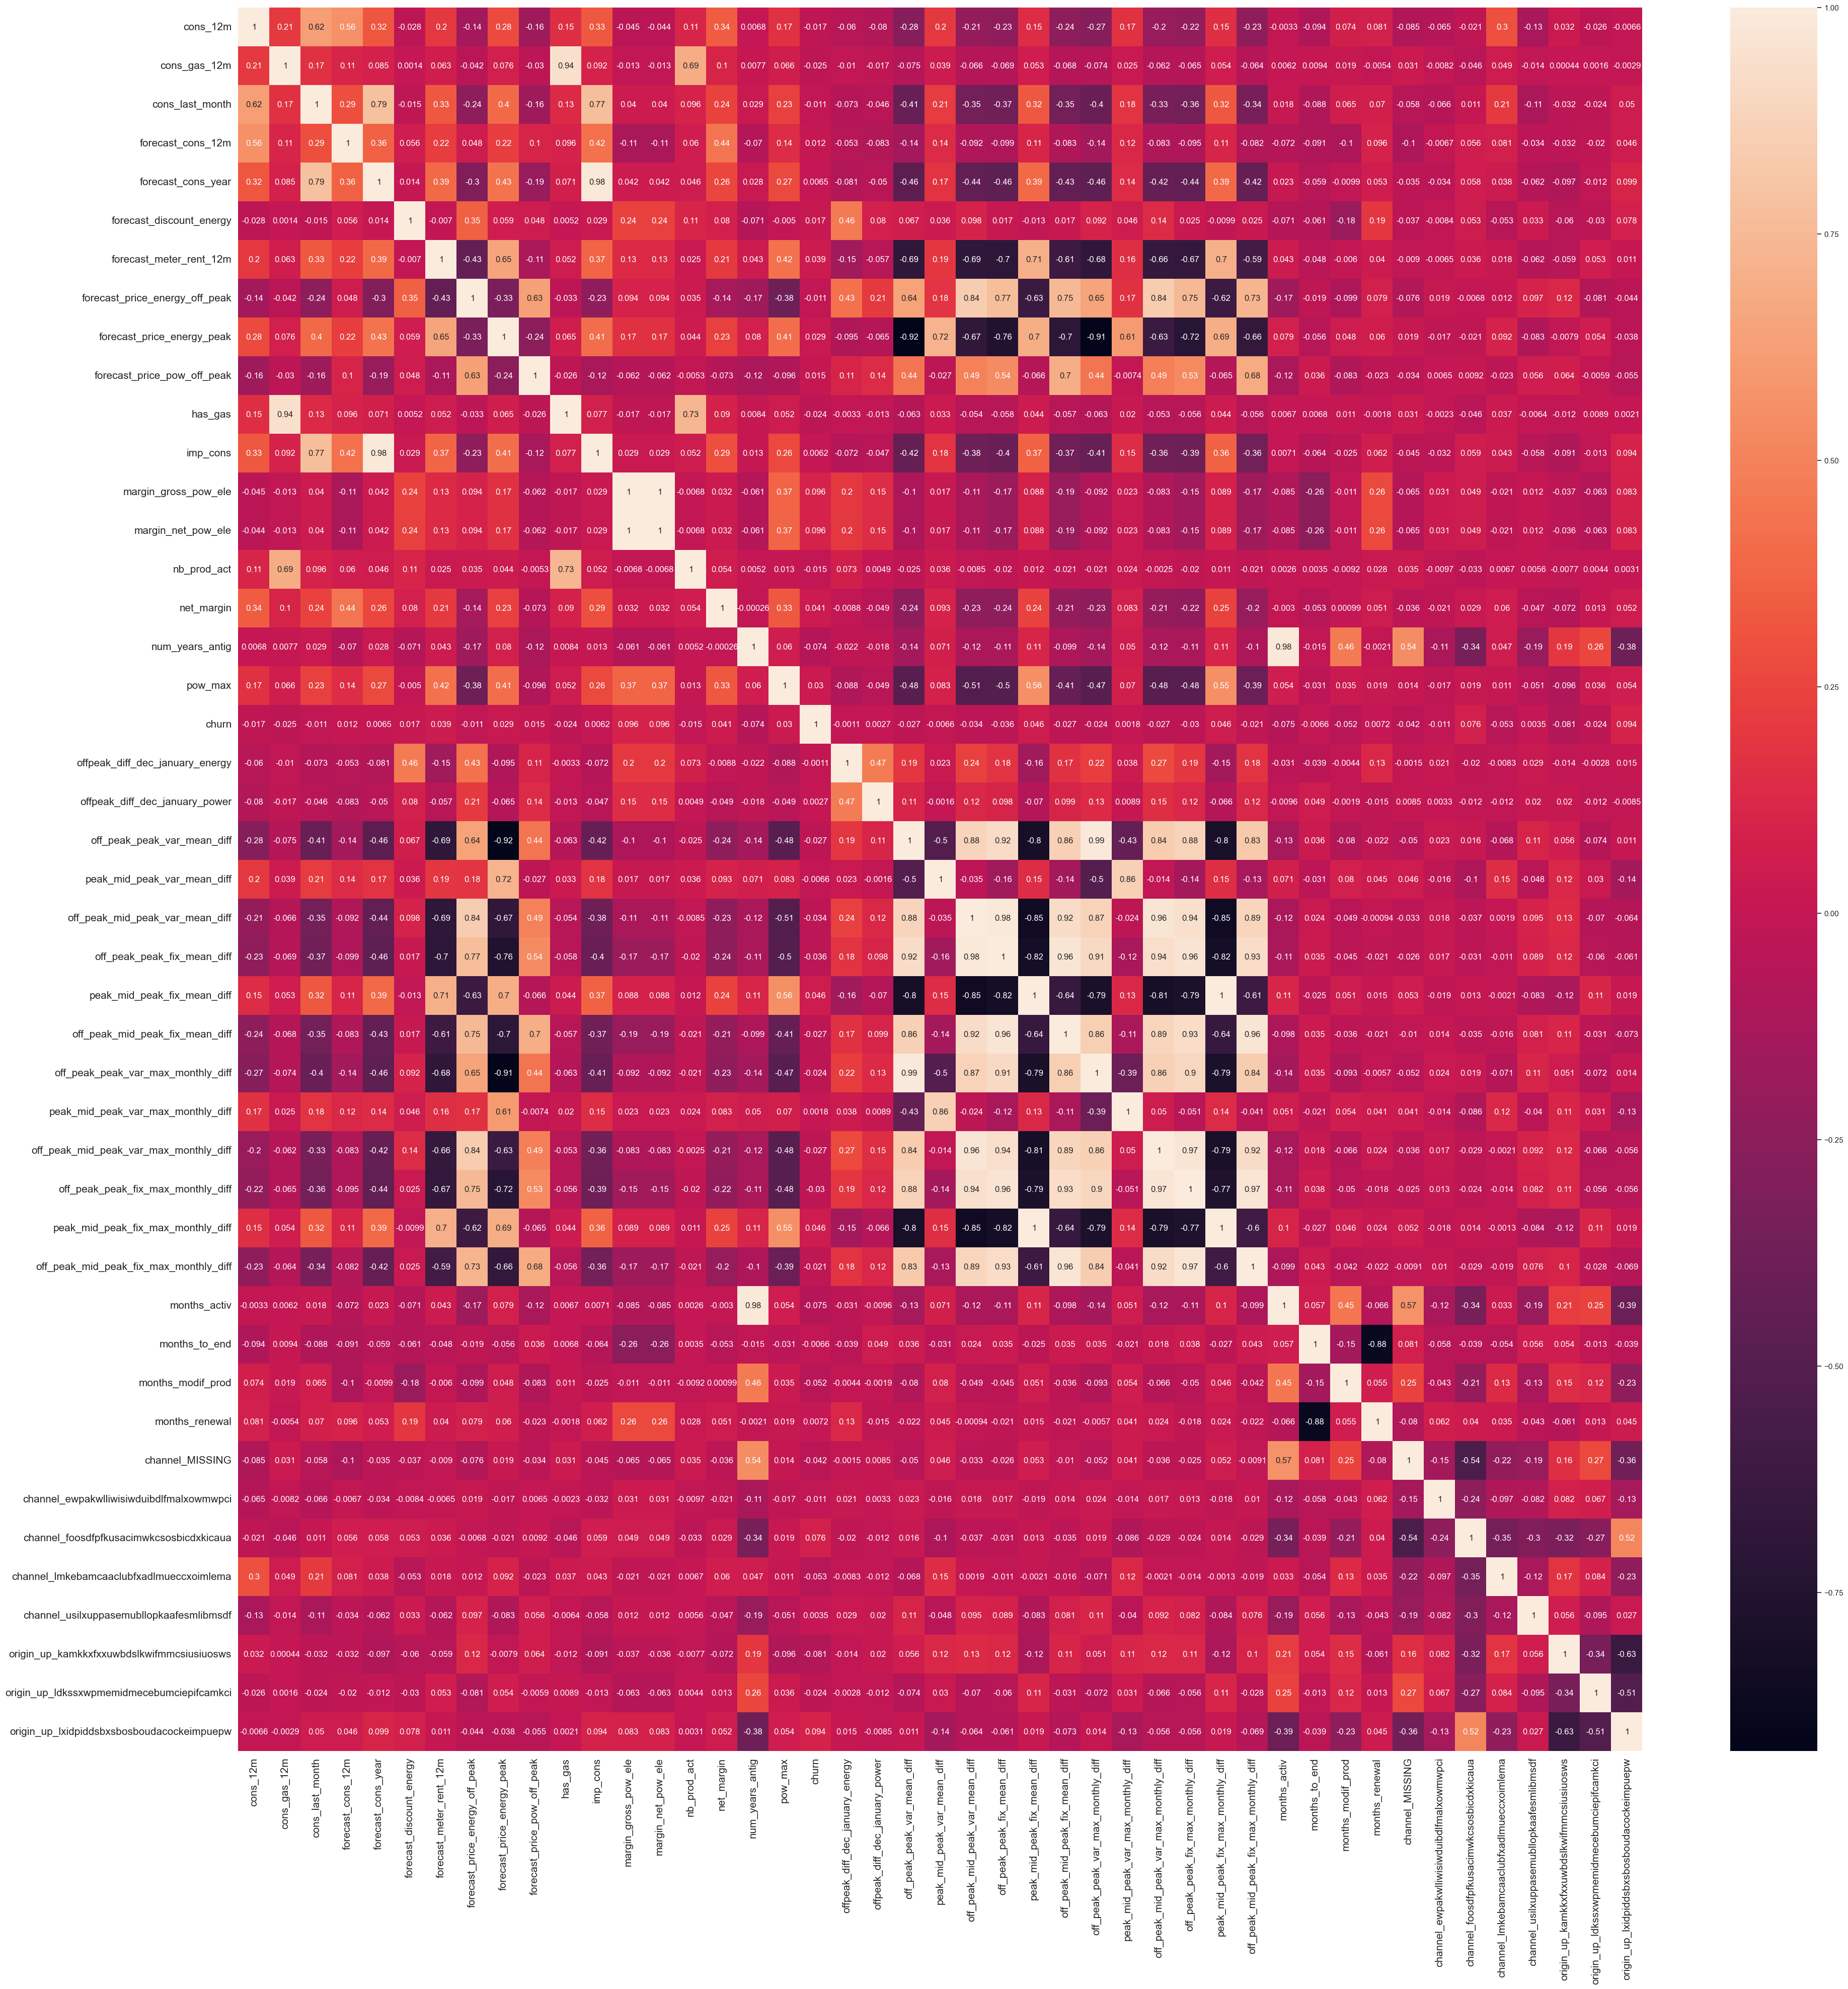

In [36]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [37]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0


---

## 5. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

In [38]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Data sampling

The first thing we want to do is split our dataset into training and test samples. The reason why we do this, is so that we can simulate a real life situation by generating predictions for our test sample, without showing the predictive model these data points. This gives us the ability to see how well our model is able to generalise to new data, which is critical.

A typical % to dedicate to testing is between 20-30, for this example we will use a 75-25% split between train and test respectively.

In [39]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 42)
(14606,)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 42)
(10954,)
(3652, 42)
(3652,)


### Model training



In [41]:
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

### Evaluation

Now let's evaluate how well this trained model is able to predict the values of the test dataset.

We are going to use 3 metrics to evaluate performance:

- Accuracy = the ratio of correctly predicted observations to the total observations
- Precision = the ability of the classifier to not label a negative sample as positive
- Recall = the ability of the classifier to find all the positive samples

The reason why we are using these three metrics is because a simple accuracy is not always a good measure to use. To give an example, let's say you're predicting heart failures with patients in a hospital and there were 100 patients out of 1000 that did have a heart failure. 

If you predicted 80 out of 100 (80%) of the patients that did have a heart failure correctly, you might think that you've done well! However, this also means that you predicted 20 wrong and what may the implications of predicting these remaining 20 patients wrong? Maybe they miss out on getting vital treatment to save their lives. 

As well as this, what about the impact of predicting negative cases as positive (people not having heart failure being predicted that they did), maybe a high number of false positives means that resources get used up on thee wrong people and a lot of time is wasted when they could have been helping the real heart failure sufferers. 

This is just an example, but it illustrates why other performance metrics are necessary such `Precision` and `Recall`, which are good measures to use in a classification scenario.

In [42]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [43]:
y_test.value_counts()

0    3286
1     366
Name: churn, dtype: int64

In [44]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 19
False positives: 2
True negatives: 3284
False negatives: 347

Accuracy: 0.9044359255202629
Precision: 0.9047619047619048
Recall: 0.05191256830601093



### Model understanding

A simple way of understanding the results of a model is to look at feature importances. Feature importances indicate the importance of a feature within the predictive model, there are several ways to calculate feature importance, but with the Random Forest classifier, we're able to extract feature importances using the built-in method on the trained model. In the Random Forest case, the feature importance represents the number of times each feature is used for splitting across all trees.

In [45]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()


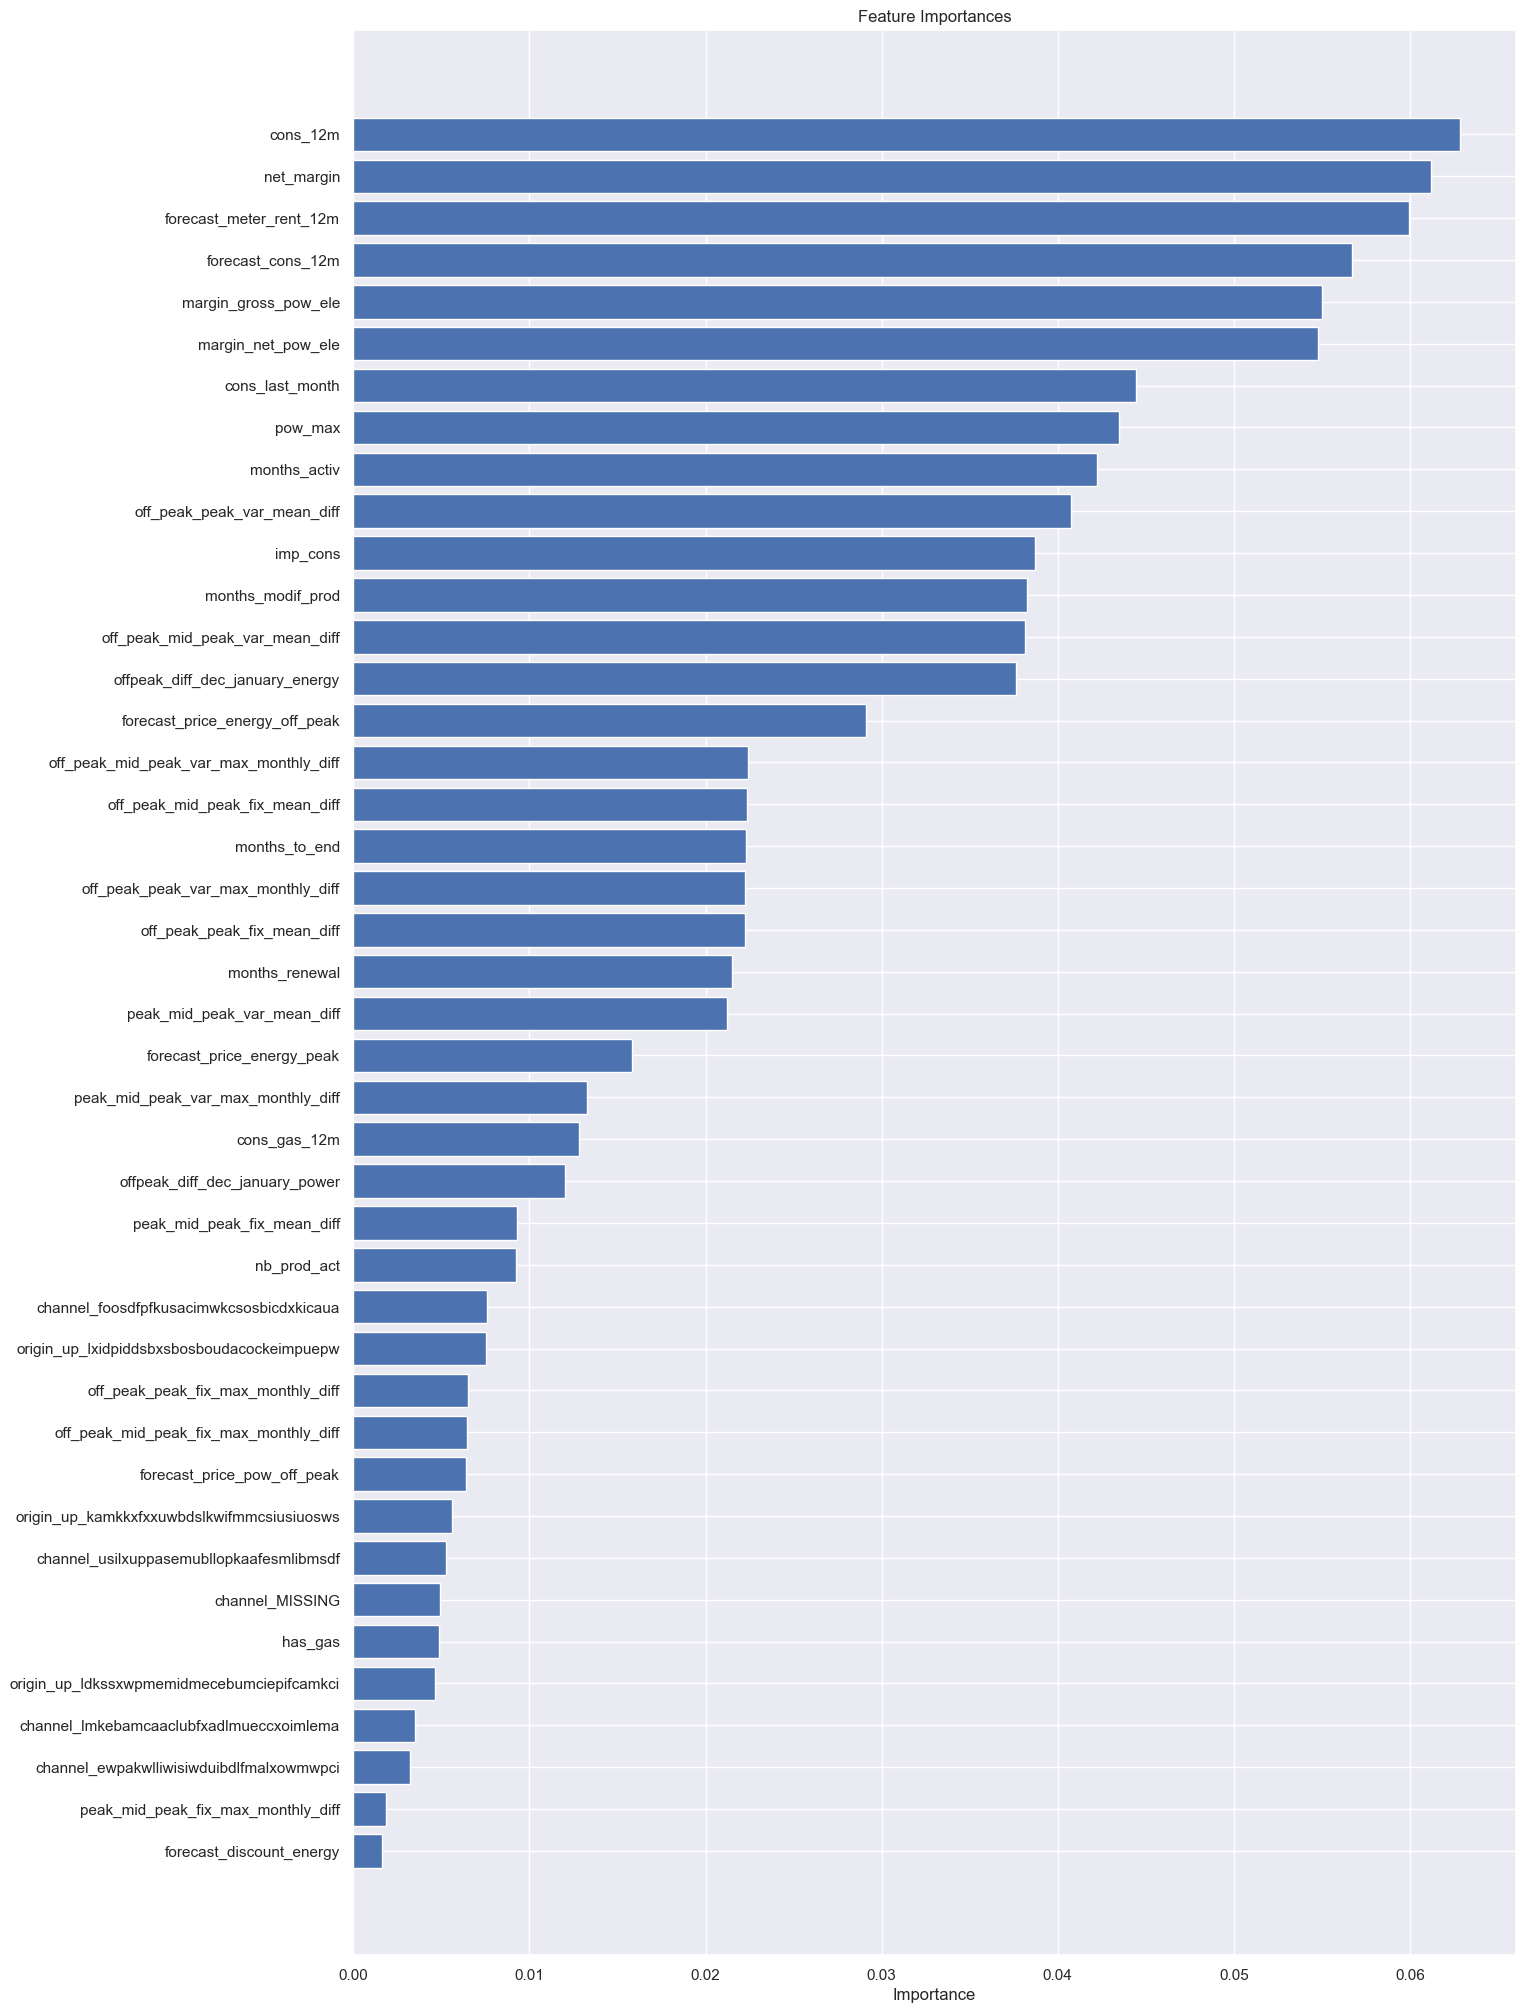

In [46]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

From this chart, we can observe the following points:

- Net margin and consumption over 12 months is a top driver for churn in this model
- Margin on power subscription also is an influential driver
- Time seems to be an influential factor, especially the number of months they have been active, their tenure and the number of months since they updated their contract
- The feature that our colleague recommended is in the top half in terms of how influential it is and some of the features built off the back of this actually outperform it
- Our price sensitivity features are scattered around but are not the main driver for a customer churning

The last observation is important because this relates back to our original hypothesis:

    > Is churn driven by the customers' price sensitivity?

Based on the output of the feature importances, it is not a main driver but it is a weak contributor. However, to arrive at a conclusive result, more experimentation is needed.

In [47]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]

In [48]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [49]:
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')